# Train and Host a Keras Model on Amazon SageMaker

Amazon SageMaker is a fully-managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK makes it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks, including TensorFlow and Keras.

In this notebook, we train and host a [Keras Sequential model](https://keras.io/getting-started/sequential-model-guide) on SageMaker. The model used for this notebook is a simple multi-layer perceptron neural network (VNN).

## Setup

First check the directory structure and modify permissions if a lost+found folder is present with root group and/or owner.

In [1]:
%%sh
ls -l

total 40
drwx------ 2 root     root     16384 May 16 07:22 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  4268 May 16 07:26 mnist_vnn_tf2.py
-rw-rw-r-- 1 ec2-user ec2-user 14714 May 16 07:26 tensorflow_vnn_mnist.ipynb


In [2]:
%%sh
sudo chown ec2-user lost+found

%%sh
sudo chgrp ec2-user lost+found

%%sh
ls -l 

total 40
drwx------ 2 ec2-user ec2-user 16384 May 16 07:22 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  4268 May 16 07:26 mnist_vnn_tf2.py
-rw-rw-r-- 1 ec2-user ec2-user 14714 May 16 07:26 tensorflow_vnn_mnist.ipynb


sh: line 3: fg: no job control
sh: line 6: fg: no job control


Next define a few variables that will be needed later. Don't forget to change the kernel to **conda_tensorflow_p36**.

In [3]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

role = get_execution_role()

## The MNIST dataset

The [MNIST dataset](https://deepai.org/dataset/mnist) is a low-complexity data collection of hand-written digits used to train and test various supervised machine learning algorithmsm. It is also considered to be the "Hello, World!" of machine learning. The database contains 70,000 28x28 black and white images representing the digits zero through nine. It is split into two subsets, with 60,000 images belonging to the training set and 10,000 images belonging to the testing set. The separation of images ensures that given what an adequately trained model has learned previously, it can accurately classify relevant images not previously examined.

### Prepare the dataset for training

In [4]:
# Import os, keras, numpy, pyplot and the MNIST data 
import os
import keras
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot

# mnist = tf.keras.datasets.mnist # get mnist from keras

(x_train, y_train), (x_val, y_val) = mnist.load_data()

Using TensorFlow backend.



11493376/11490434 [==============================] - 4s 0us/step


x_train_shape & data type: ((60000, 28, 28), dtype('uint8'))
y_train_shape & data type: ((60000,), dtype('uint8'))


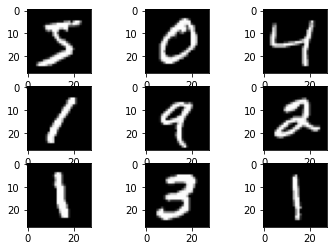

In [5]:
# Take a quick look at data 

#Each image is represented as a 28x28 pixel grayscale images
## View shape and type of data
xtr = x_train.shape, x_train.dtype
ytr = y_train.shape, y_train.dtype

print("x_train_shape & data type:", xtr)
print("y_train_shape & data type:", ytr)

# plot some raw pixel data
for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

In [6]:
# Create local directory for the data and save the training and test data there
os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_val, label=y_val)

In [7]:
%%sh 
ls -l data ## Check that the directories have been created and the files have been saved successfully

total 53668
-rw-rw-r-- 1 ec2-user ec2-user  7850506 May 16 07:29 test.npz
-rw-rw-r-- 1 ec2-user ec2-user 47100506 May 16 07:29 training.npz


### Verify the training code

Next train the model on the local instance - this is an optional step and is to check if the code will run on AWS. The model is trained using TensorFlow() to create a tf_estimator object.

In more detail, before running the baseline training job, [the SageMaker Python SDK's Local Mode feature](https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode) is first used to check that the code works with SageMaker's TensorFlow environment. Local Mode downloads the [prebuilt Docker image for TensorFlow](https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html) and runs a Docker container locally for a training job. A TensorFlow estimator is created, and the `instance_type` is specified as to be `'local'` or `'local_gpu'`, depending on the local instance type. This tells the estimator to run the training job locally (as opposed to on SageMaker). The  training code is also only run for only one epoch because the intent is to verify the code, not train an accurate model.

**Don't forget to upload the python script into the same notebook instance.**

In [ ]:
# Import tensorflow from sagemaker
from sagemaker.tensorflow import TensorFlow

# Set environment variables - file paths to data and for output
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'
output = 'file:///output'

instance_type = "local"

if subprocess.call("nvidia-smi") == 0:
    instance_type = "local_gpu" # set instance_type to GPU if one is present
    
local_hyperparameters = {"epochs": 1, "batch-size": 64}

tf_estimator = TensorFlow(entry_point='mnist_vnn_tf2.py', # path to local python source file to be executed
                          role = role, # the IAM ROLE ARN for the model - unique user ID
                          source_dir ='.', # path to the directory where any other dependancies are apart from entry point
                          instance_count = 1, #the number of EC2 intances to use
                          instance_type = instance_type, # Type of EC2 instance to use local = this one! 
                          framework_version = '2.1.0', # Tensorflow version for executing the tf code
                          py_version ='py3',
                          script_mode =True,
                          hyperparameters=local_hyperparameters,
                          output_path = output) # location for saving the results. Default = saved in the default S3 bucket.

In [ ]:
# fit is used to train the model saved in the estimator object. The local files paths to the traiing and test data also 
# need to be passed in
tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

### Train and tune the model in AWS

Now that it has been determined the code is working on SageMaker (note, this is only possible because it's a small dataset and a shallow neural network - it won't work with large datasets or deep neural networks), the model can be trained on a larger instance. 

1. Upload the dataset to S3. S3 is a default bucket for storing data and model output in AWS
2. Select the [EC2 instance type](https://aws.amazon.com/ec2/instance-types/) for the model. MA5852 will mainly use *ml.m4.xlarge*. EC stands for Elastic Compute Cloud, and its a web service where AWS subscribers can request and provision compute services in the AWS cloud. The user is charged per hour with different rates, depending on the instance chosen. Don't forget to terminate the instance when done to stop being over-charged. 

In [8]:
from sagemaker.s3 import S3Uploader

prefix = 'keras-mnist'

training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')
test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

print(training_input_path)
print(test_input_path)

s3://sagemaker-ap-southeast-2-987959606453/keras-mnist/training/training.npz
s3://sagemaker-ap-southeast-2-987959606453/keras-mnist/validation/test.npz


In [48]:
datasets = sess.upload_data(path='data', key_prefix='mnist-HPO')
print(datasets) 

s3://sagemaker-ap-southeast-2-987959606453/mnist-HPO


In [52]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparams = {'epochs': 2,
               'batch-size': 256
}

bucket_name = sess.default_bucket()
output_path = f's3://{bucket_name}/jobs'

tf_estimator = TensorFlow(
    entry_point="mnist_vnn_tf2.py",
    output_path=f'{output_path}/',
    role = role,
    source_dir='.',
    hyperparameters=hyperparams,
    framework_version="2.1.0",
    py_version="py3",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    script_mode = True,
)

In [53]:
tf_estimator.fit({'training': datasets,
                 'validation': datasets})

2021-05-16 08:36:56 Starting - Starting the training job...
2021-05-16 08:36:57 Starting - Launching requested ML instancesProfilerReport-1621154194: InProgress
......
2021-05-16 08:38:11 Starting - Preparing the instances for training......
2021-05-16 08:39:15 Downloading - Downloading input data...
2021-05-16 08:39:52 Training - Downloading the training image..
2021-05-16 08:40:23 Uploading - Uploading generated training model2021-05-16 08:40:08,053 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-16 08:40:08,066 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-16 08:40:09,070 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-16 08:40:09,095 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-16 08:40:09,117 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-16 08:40:09,130 sagemaker-containers INFO  

### Tune the model hyperparameters

To run a model tuning job, you need to provide Amazon SageMaker with hyperparameter ranges rather than fixed values, so that it can explore the hyperparameter space and automatically find the best values for you.

In [54]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

# add the details of the hyperparameters being tuned / set
hyperparameter_ranges = {
    'learning_rate':  ContinuousParameter(0.01, 0.2)
}

# specify the objective metric to be tuned and its definition, including the regex required to extract that metric from the
# CloudWatch logs of the training job.
objective_metric_name  = 'accuracy'
objective_type  = 'Maximize'
metric_definitions  = [{'Name': 'accuracy', 'Regex': 'accuracy = ([0-9\\.]+)'}] 

tf_estimator = TensorFlow(
    entry_point="mnist_vnn_tf2.py",
    output_path=f'{output_path}/',
    role = role,
    source_dir='.',
    hyperparameters=hyperparameters,
    framework_version="2.1.0",
    py_version="py3",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    script_mode = True,
)

# create the HyperparameterTuner object, and pass in the TensorFlow estimator, hyperparameter ranges, objective name and
# definition, and tuning resource configuration
tf_tuner = HyperparameterTuner(estimator = tf_estimator,
                               objective_metric_name = objective_metric_name,
                               objective_type = objective_type,
                               metric_definitions = metric_definitions,
                               hyperparameter_ranges = hyperparameter_ranges,
                               max_jobs=2,
                               max_parallel_jobs=2)

In [55]:
# run the tuning job
tf_tuner.fit({'training': datasets,
              'validation': datasets})

..............................................!


In [56]:
# analyse the training job
import boto3

region = boto3.Session().region_name
sage_client = boto3.Session().client("sagemaker")

tuning_job_name = 'tensorflow-training-210516-0842'

print(region)
print(sage_client)
print(tuning_job_name)

ap-southeast-2
tensorflow-training-210516-0842


In [57]:
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_minimize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"] != "Maximize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["MetricName"]
print(is_minimize)
print(objective_name)

2 training jobs have completed
False
accuracy


In [58]:
print(tuning_job_result)

{'HyperParameterTuningJobName': 'tensorflow-training-210516-0842', 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:ap-southeast-2:987959606453:hyper-parameter-tuning-job/tensorflow-training-210516-0842', 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian', 'HyperParameterTuningJobObjective': {'Type': 'Maximize', 'MetricName': 'accuracy'}, 'ResourceLimits': {'MaxNumberOfTrainingJobs': 2, 'MaxParallelTrainingJobs': 2}, 'ParameterRanges': {'IntegerParameterRanges': [], 'ContinuousParameterRanges': [{'Name': 'learning_rate', 'MinValue': '0.01', 'MaxValue': '0.2', 'ScalingType': 'Auto'}], 'CategoricalParameterRanges': []}, 'TrainingJobEarlyStoppingType': 'Off'}, 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'accuracy', 'batch-size': '256', 'epochs': '2', 'model_dir': '"s3://sagemaker-ap-southeast-2-987959606453/jobs/tensorflow-training-2021-05-16-08-42-01-276/model"', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"TensorFlo

In [41]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

No training jobs have reported results yet.


In [42]:
import pandas as pd

tuner2 = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

No training jobs have reported valid results yet.


,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds


### Deploy the best model

In [43]:
tuner.deploy(initial_instance_count=1, instance_type='ml.t2.large')

AttributeError: 'HyperparameterTuningJobAnalytics' object has no attribute 'deploy'

## Deploy the trained model

After the model is trained, it can be deployed to a SageMaker Endpoint, which serves prediction requests in real-time. To do so, simply call `deploy()` on the estimator, passing in the desired number of instances and instance type for the endpoint.

In [ ]:
import time

tf_endpoint_name = 'keras-tf-mnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()) #give the endpoint a name.
# used the time and date from the time library

# deploy() deploys the model to an endpoint and optionally return a predictor.
tf_predictor = tf_estimator.deploy(initial_instance_count=1, # The initial number of instances to run in the endpoint created from this Model.
                                   instance_type='ml.m4.xlarge', # The EC2 instance type to deploy this model to.
                                   endpoint_name=tf_endpoint_name) # The name of the endpoint to create   

Now use the test dataset for predictions

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


def predict(data):
    predictions = predictor.predict(data)["predictions"]
    return predictions


predicted = []
actual = []
batches = 0
batch_size = 128

datagen = ImageDataGenerator()
for data in datagen.flow(x_test, y_test, batch_size=batch_size):
    for i, prediction in enumerate(predict(data[0])):
        predicted.append(np.argmax(prediction))
        actual.append(data[1][i][0])

    batches += 1
    if batches >= len(x_test) / batch_size:
        break

Use the predictions to calculate model accuracy and create a confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_pred=predicted, y_true=actual)
display("Average accuracy: {}%".format(round(accuracy * 100, 2)))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=predicted, y_true=actual)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={"figure.figsize": (11.7, 8.27)})
sn.set(font_scale=1.4)  # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 10})  # font size

### Clean-up - Delete the endpoint

Remember to delete the endpoint to avoid unnecessary surcharge from AWS.

In [ ]:
tf_predictor.delete_endpoint()